In [1]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel
from ntwrk.bayesopt import Surrogate, BayesOpt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def true_func(x, noise=0.1):
    return 0.6 * torch.sin(3 * (x-1.)) + torch.sin(1.2 * x) + noise * torch.randn(x.shape)

In [3]:
test_x = torch.linspace(0, 5, 100)
true_y = true_func(test_x, noise=0.)

In [4]:
n_train = 30
train_x = torch.rand(n_train)
cutoff = int(n_train/2)
train_x[:cutoff] = train_x[:cutoff]*2
train_x[cutoff:] = train_x[cutoff:]*2 + 3
train_y = true_func(train_x, noise=0.1)

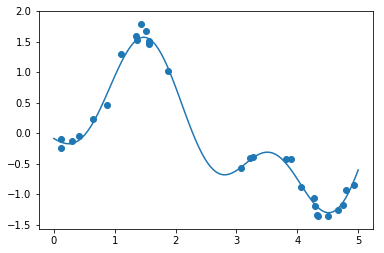

In [5]:
plt.plot(test_x, true_y.detach())
plt.scatter(train_x, train_y.detach())
plt.show()

## Some Prior Draws

In [6]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = Surrogate(test_x, true_y, lh, RBFKernel)

In [7]:
model.train()
lh.train();

n_samples = 4
samples = model(test_x).sample(sample_shape=torch.Size((n_samples,))).squeeze()


/home/vagrant/workspace/gpytorch/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


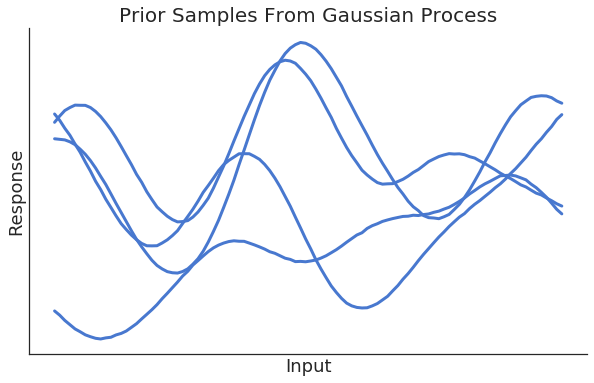

In [8]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
for smp in range(n_samples):
    plt.plot(test_x, samples[smp, :].detach(), color=colors[0],
            linewidth=lwd)

# plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
#         label="Observations", color=colors[1], markersize=5)
# plt.plot(test_x, pred_mean.detach(), label="Predicted Mean", color=colors[0],
#         linewidth=lwd)
# plt.fill_between(test_x, lower.detach(), upper.detach(),
#                 alpha=0.2)

plt.title("Prior Samples From Gaussian Process", fontsize=title_fs)
plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend( fontsize=leg_fs)
plt.show()

## Train and Get Posterior Samples

In [9]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = Surrogate(train_x, train_y, lh, RBFKernel)

In [10]:
model.train()
lh.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # print(loss.item())

In [11]:
model.eval()
lh.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [12]:
pred_dist = lh(model(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

In [13]:
import seaborn as sns

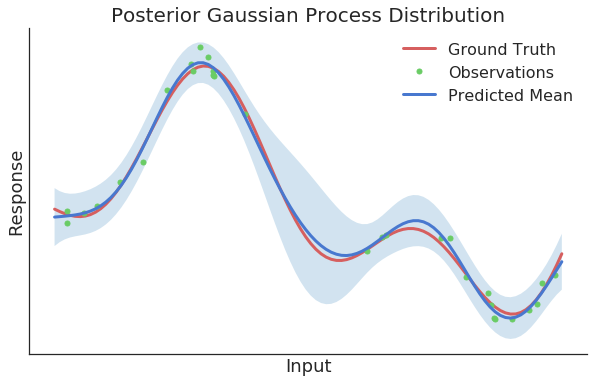

In [14]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd)
plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=5)
plt.plot(test_x, pred_mean.detach(), label="Predicted Mean", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Posterior Gaussian Process Distribution",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

## Bayesian Optimization

In [32]:
train_x = torch.rand(3) * 5
train_y = true_func(train_x)

In [33]:
bayesopt = BayesOpt(train_x, train_y, normalize=True, normalize_y=True, max_x=5.)

In [34]:
bayesopt.surrogate.train()
bayesopt.surrogate_lh.train()

optimizer = torch.optim.Adam(bayesopt.surrogate.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(bayesopt.surrogate_lh,
                                               bayesopt.surrogate)

for i in range(200):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = bayesopt.surrogate(bayesopt.train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, bayesopt.train_y)
    loss.backward()
    optimizer.step()
    print(loss.item())

1.3349933624267578
1.3334051370620728
1.3318313360214233
1.3302520513534546
1.3286798000335693
1.3271156549453735
1.3255525827407837
1.323990821838379
1.3224343061447144
1.320883870124817
1.319337010383606
1.317792296409607
1.3162511587142944
1.3147152662277222
1.3131834268569946
1.3116544485092163
1.310127854347229
1.3086049556732178
1.3070859909057617
1.3055697679519653
1.3040553331375122
1.3025431632995605
1.3010334968566895
1.2995260953903198
1.2980197668075562
1.2965143918991089
1.2950102090835571
1.2935069799423218
1.292004108428955
1.2905009984970093
1.288997769355774
1.2874945402145386
1.285990595817566
1.2844854593276978
1.2829794883728027
1.2814725637435913
1.2799639701843262
1.2784538269042969
1.2769421339035034
1.275429129600525
1.2739142179489136
1.2723976373672485
1.2708797454833984
1.269360065460205
1.2678390741348267
1.2663166522979736
1.2647931575775146
1.2632688283920288
1.261743426322937
1.2602177858352661
1.258691668510437
1.257165551185608
1.255639672279358
1.25411

In [30]:
bayesopt.train_surrogate(200)

train x =  tensor([0.0854, 0.4448, 0.1599])
train y =  tensor([-0.2666,  0.2380,  0.5154])
Surrogate(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)
0.5348365902900696
199271168.0
12907592.0
42509484.0
114900224.0
87593376.0
25703336.0
53167.09375
23304718.0
53686944.0
53594436.0
28030662.0
4348136.0
1848882.125
16811826.0
29706214.0
27137054.0
13220741.0
1618370.125
1461714.875
9869799.0
16407268.0
14352509.0
6448417.5
522373.78125
1274959.625
6264980.5
9327760.0
7285622.0
2613514.0
29854.3359375
1428010.625
4367548.0
5233933.5
3197779.0
636977.6875
120005.96875
1640680.375
3007172.0
2570168.75
955681.3125
9751.013671875
543398.5
1572630.5
1718044.375
858223.6875


In [23]:
bayesopt.surrogate

Surrogate(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [19]:
next_query = bayesopt.acquire()

hitting boundary


In [20]:
bayesopt.surrogate.eval();
bayesopt.surrogate_lh.eval();

pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

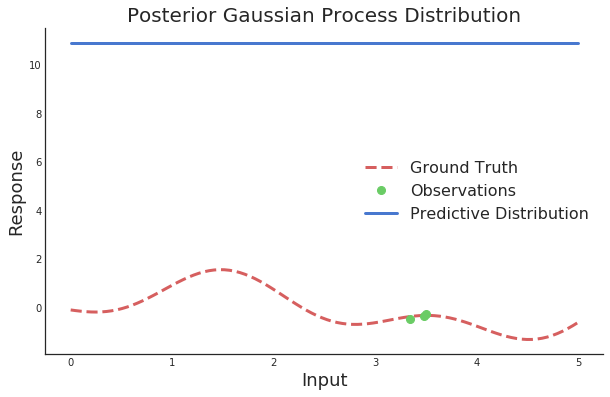

In [21]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd, linestyle="--")
plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=8)
plt.plot(test_x, pred_mean.detach(), label="Predictive Distribution", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Posterior Gaussian Process Distribution",
         fontsize=title_fs)
# plt.xticks([])
# plt.yticks([])
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

In [22]:
bayesopt.surrogate.train_targets

tensor([-0.4646, -0.3491, -0.2540])